    The data set that I am using is a collection of accelerometer data taken from a smartphone that various people carried with them while conducting six different exercises (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking). For each exercise the acceleration for the x, y, and z axis was measured and captured with a timestamp and person ID.
    
    With this available data, we would like to train a neural network in order to understand if a person carrying a smartphone is performing any of the six activities. Once the neural network has been trained on the existing data, it should be able to correctly predict the type of activity a person is conducting when given previously unseen data.
    
    Based on the available data the DL model will learn how to differentiate between each of the six activities. We can then show new data to the neural network and it will tell us what the user is doing at any particular point in time. The solution to this problem is depicted in the figure below.

<img src ='pics/1.png'>

In [1]:
#from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
#import coremltools
from scipy import stats
#from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

2023-11-22 15:22:16.986652: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

keras version  2.12.0


    TIME_PERIODS - length of the time segment
    STEP_DISTANCE - amount of overlap between two consecutive time segments

In [4]:
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

### Load Data

In [5]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [6]:
# Load data set containing all the data from csv
df = read_data('dataset/WISDM_ar_v1.1_raw.txt')

/tmp/ipykernel_58099/1891720362.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


In [7]:
# Describe the data
show_basic_dataframe_info(df)
df.head()

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098208



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


In [8]:
df.tail()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
1098204,19,Sitting,131623331483000,9.0,-1.6,1.7
1098205,19,Sitting,131623371431000,9.0,-1.5,1.7
1098206,19,Sitting,131623411592000,9.1,-1.4,1.7
1098207,19,Sitting,131623491487000,9.0,-1.5,1.7
1098208,19,Sitting,131623531465000,8.9,-1.3,1.6


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x-axis     1098208 non-null  float64
 4   y-axis     1098208 non-null  float64
 5   z-axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


### Exloratory Data Analysis

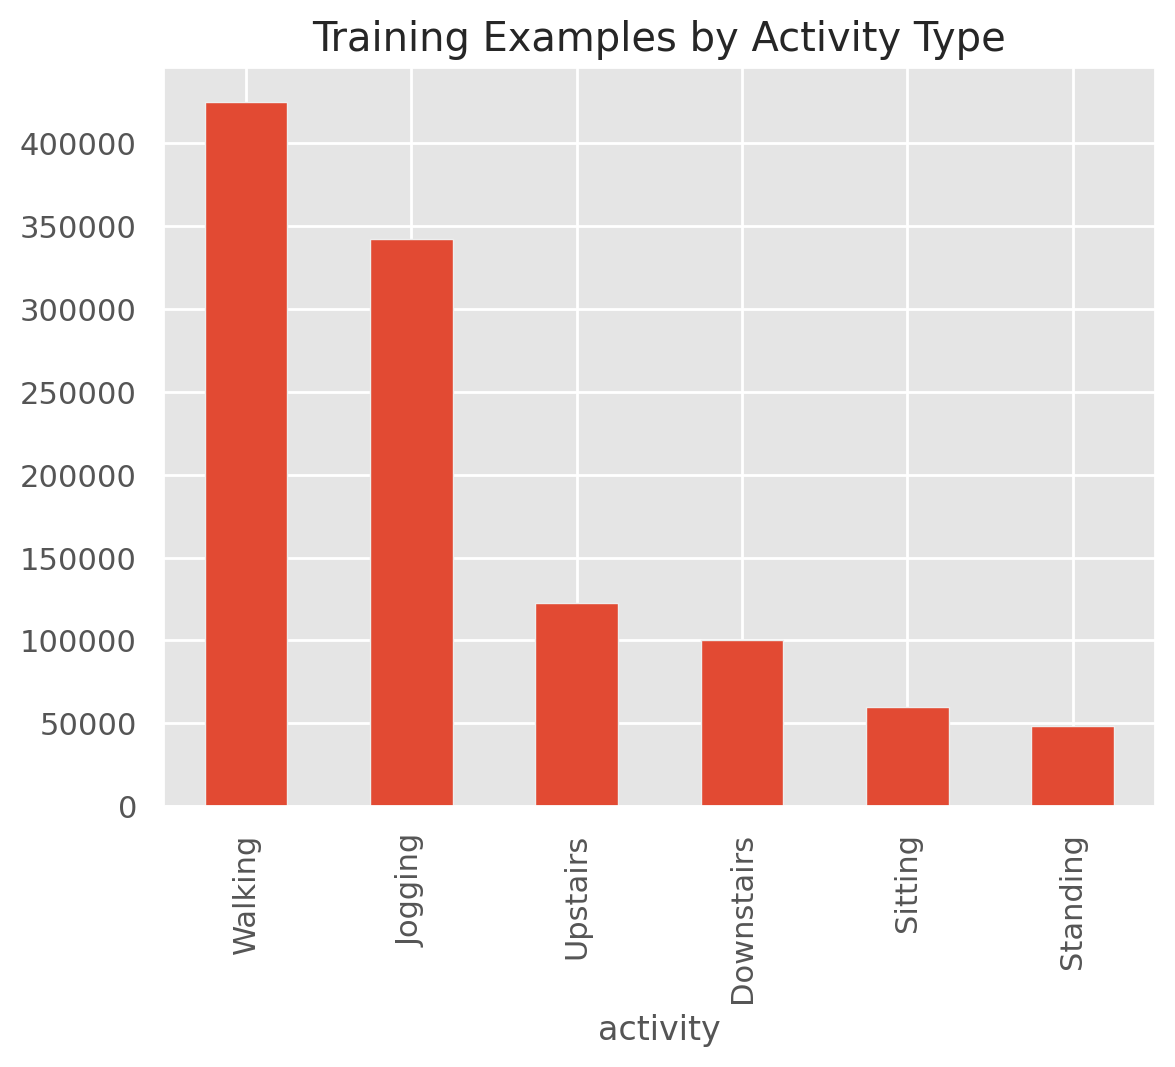

In [10]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

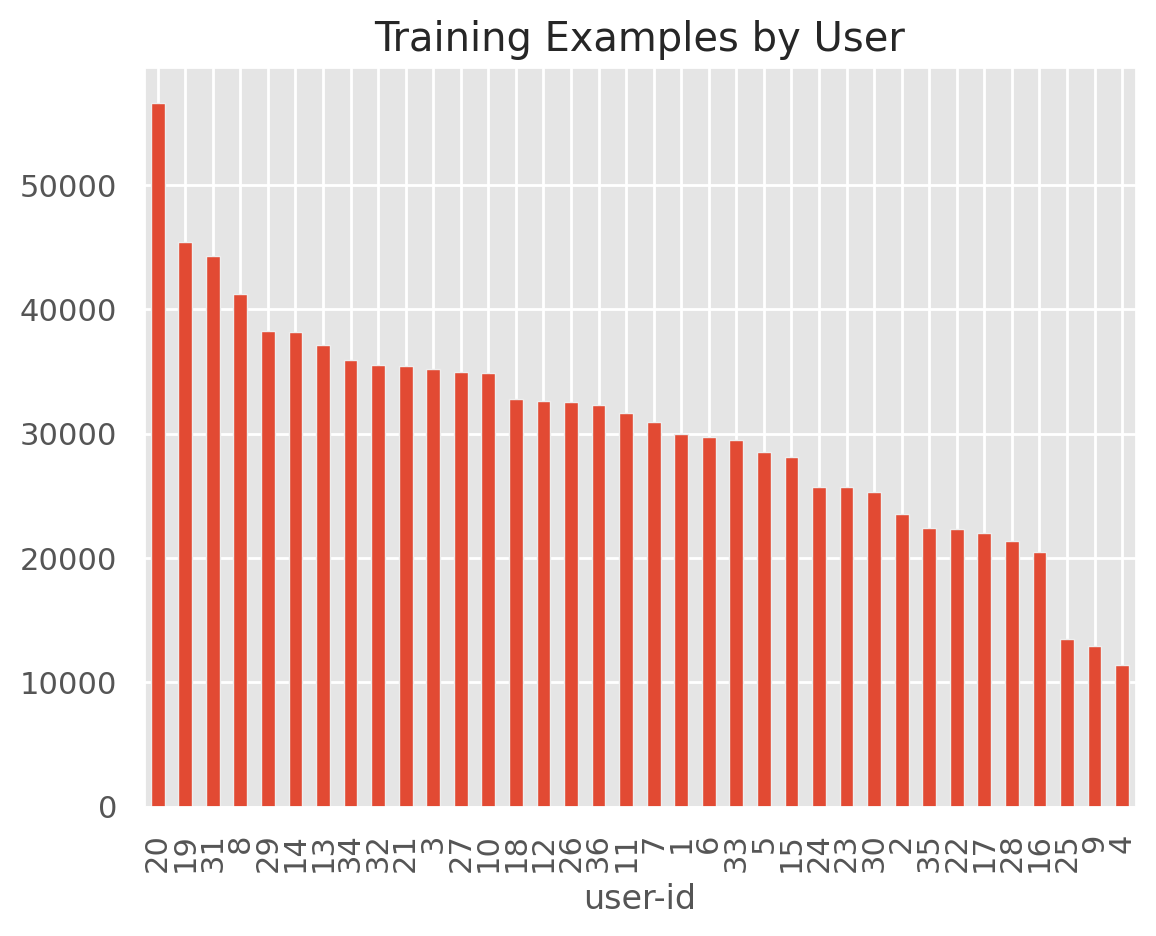

In [11]:
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

In [12]:
print(set(df['user-id']))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


In [13]:
len(set(df['user-id']))

36

As we can see, we have more data for walking and jogging activities than we have for the other activities. Also we can see that 36 persons have participated in the experiment. 

### Data Visualization

Next, let's take a look at the accelerometer data for each of the three axis for all six possible activities. The data is recorded at a sampling rate of 20 Hz (20 values per second). Since we show the first 180 records, each chart shows a 9 second interval for each of the six activities (calculation: 0.05 * 180 = 9 seconds). 

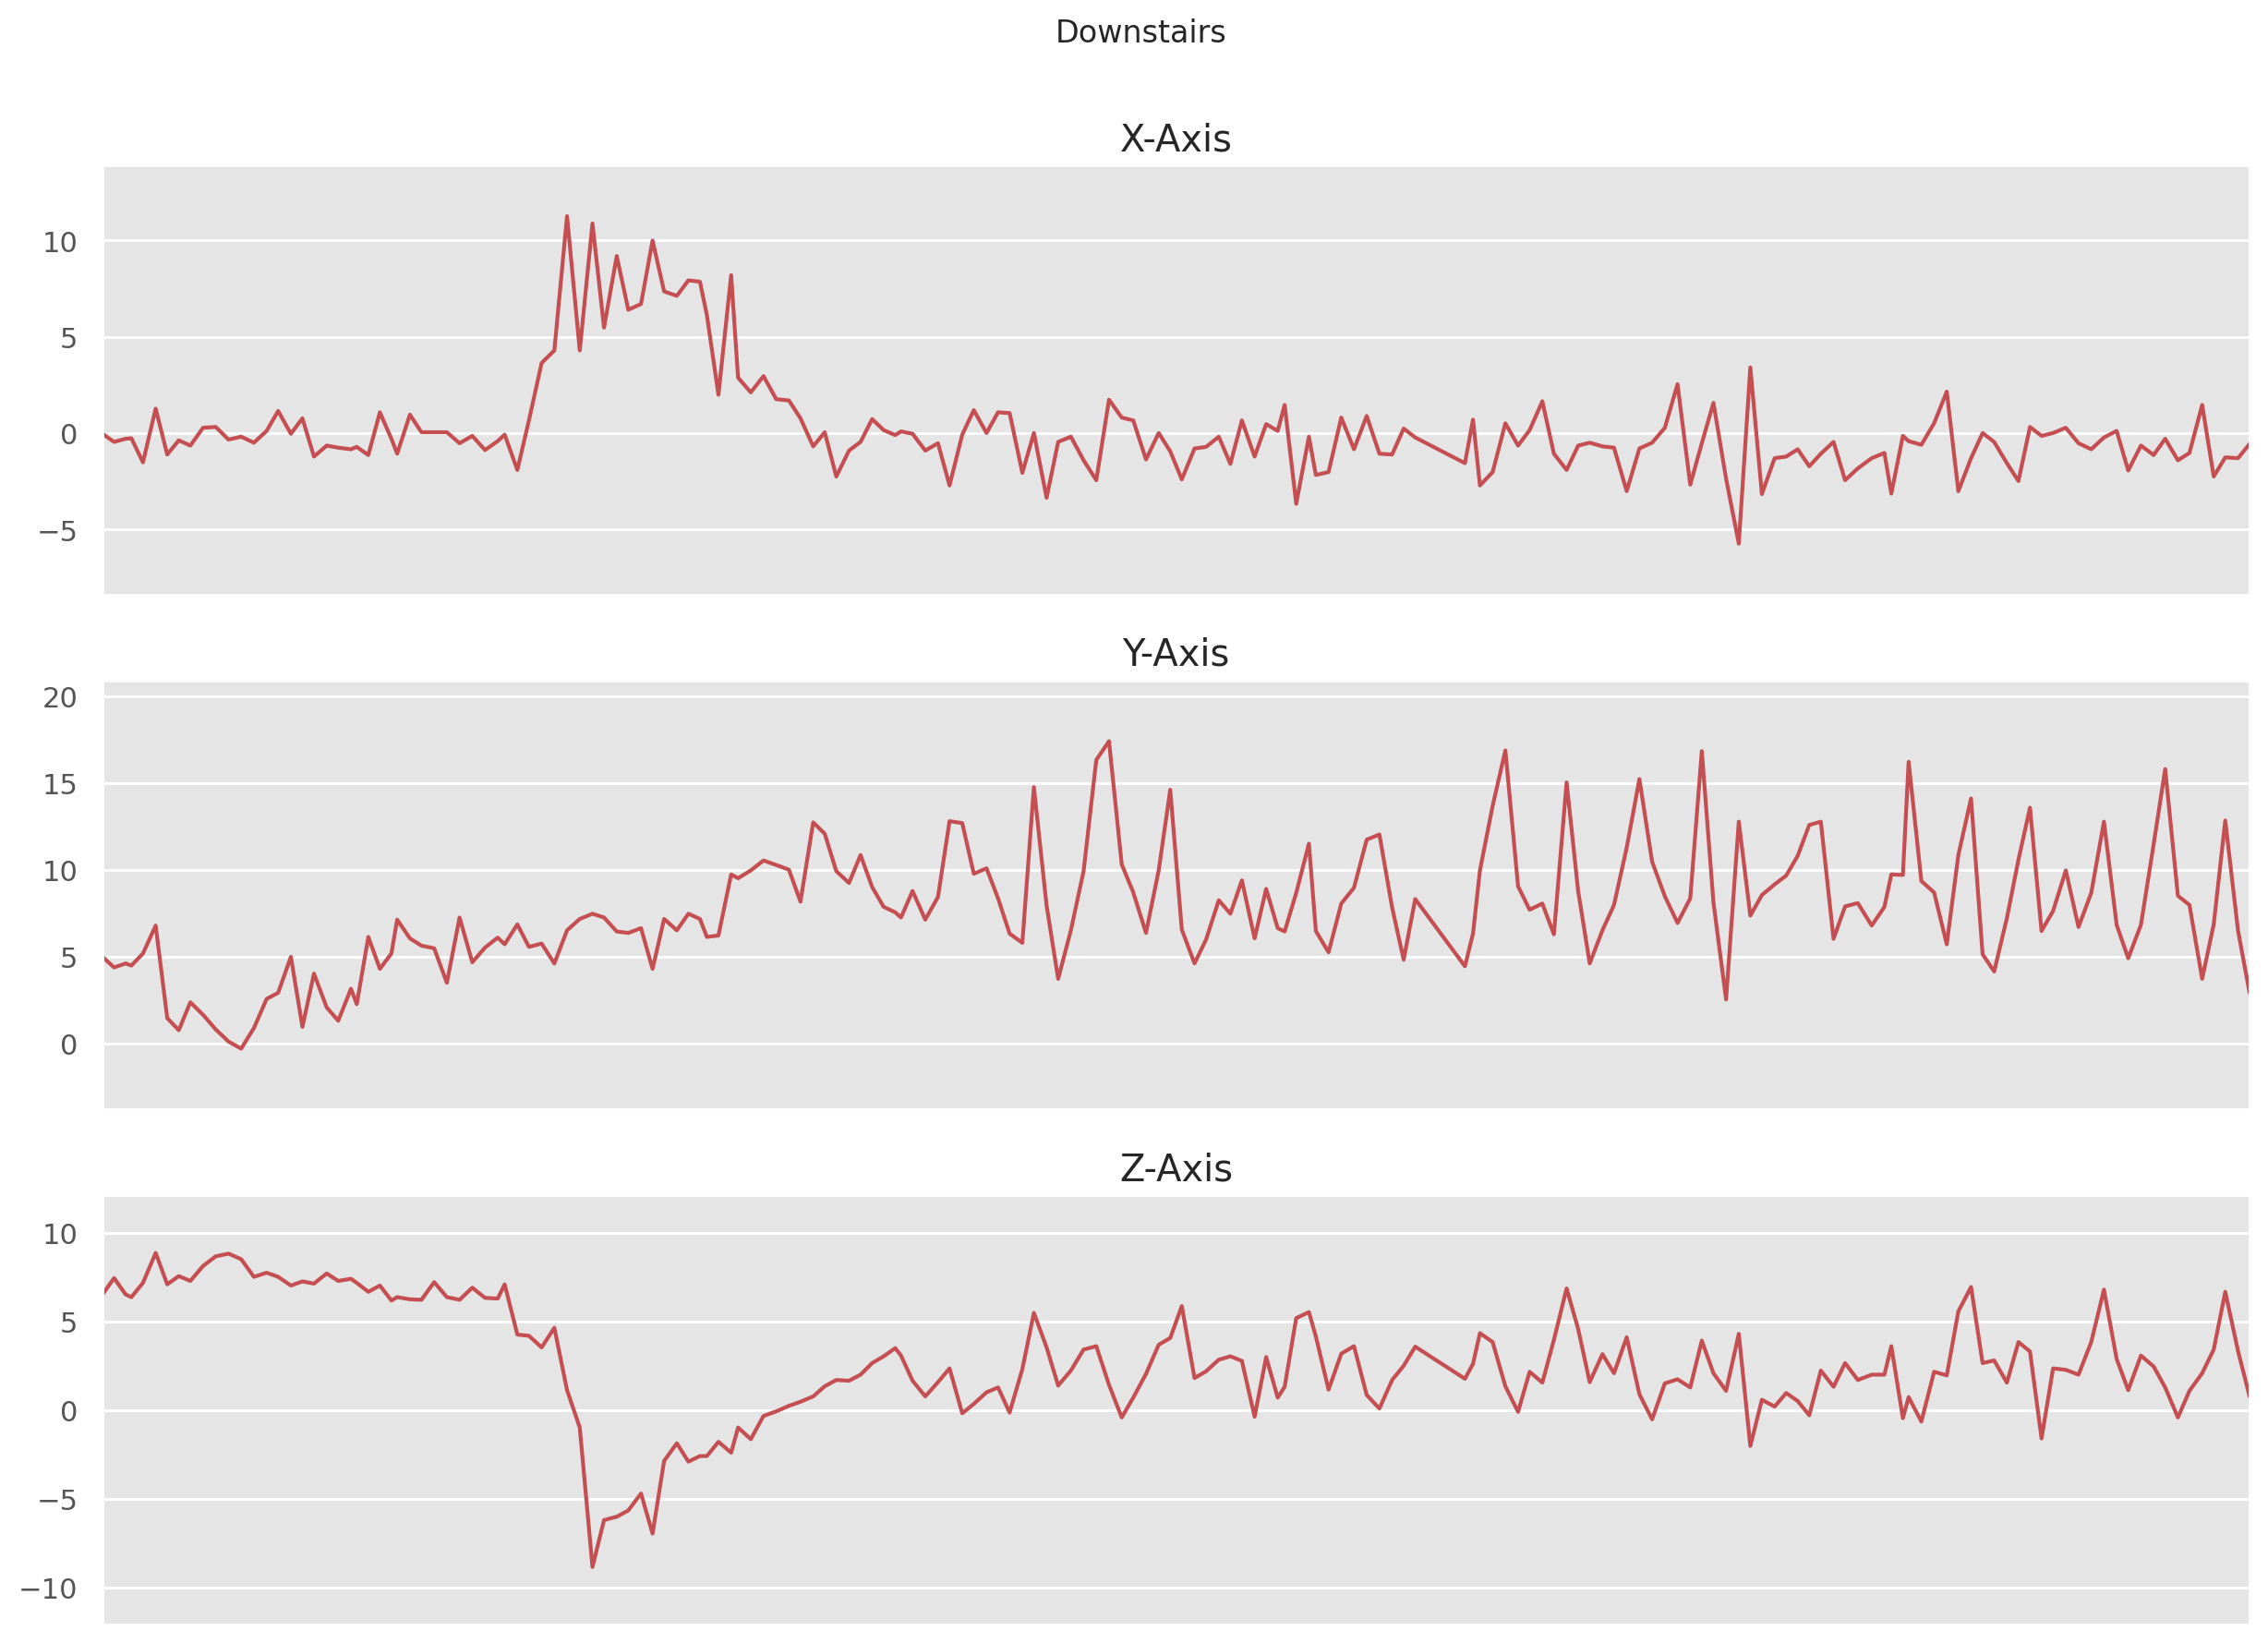

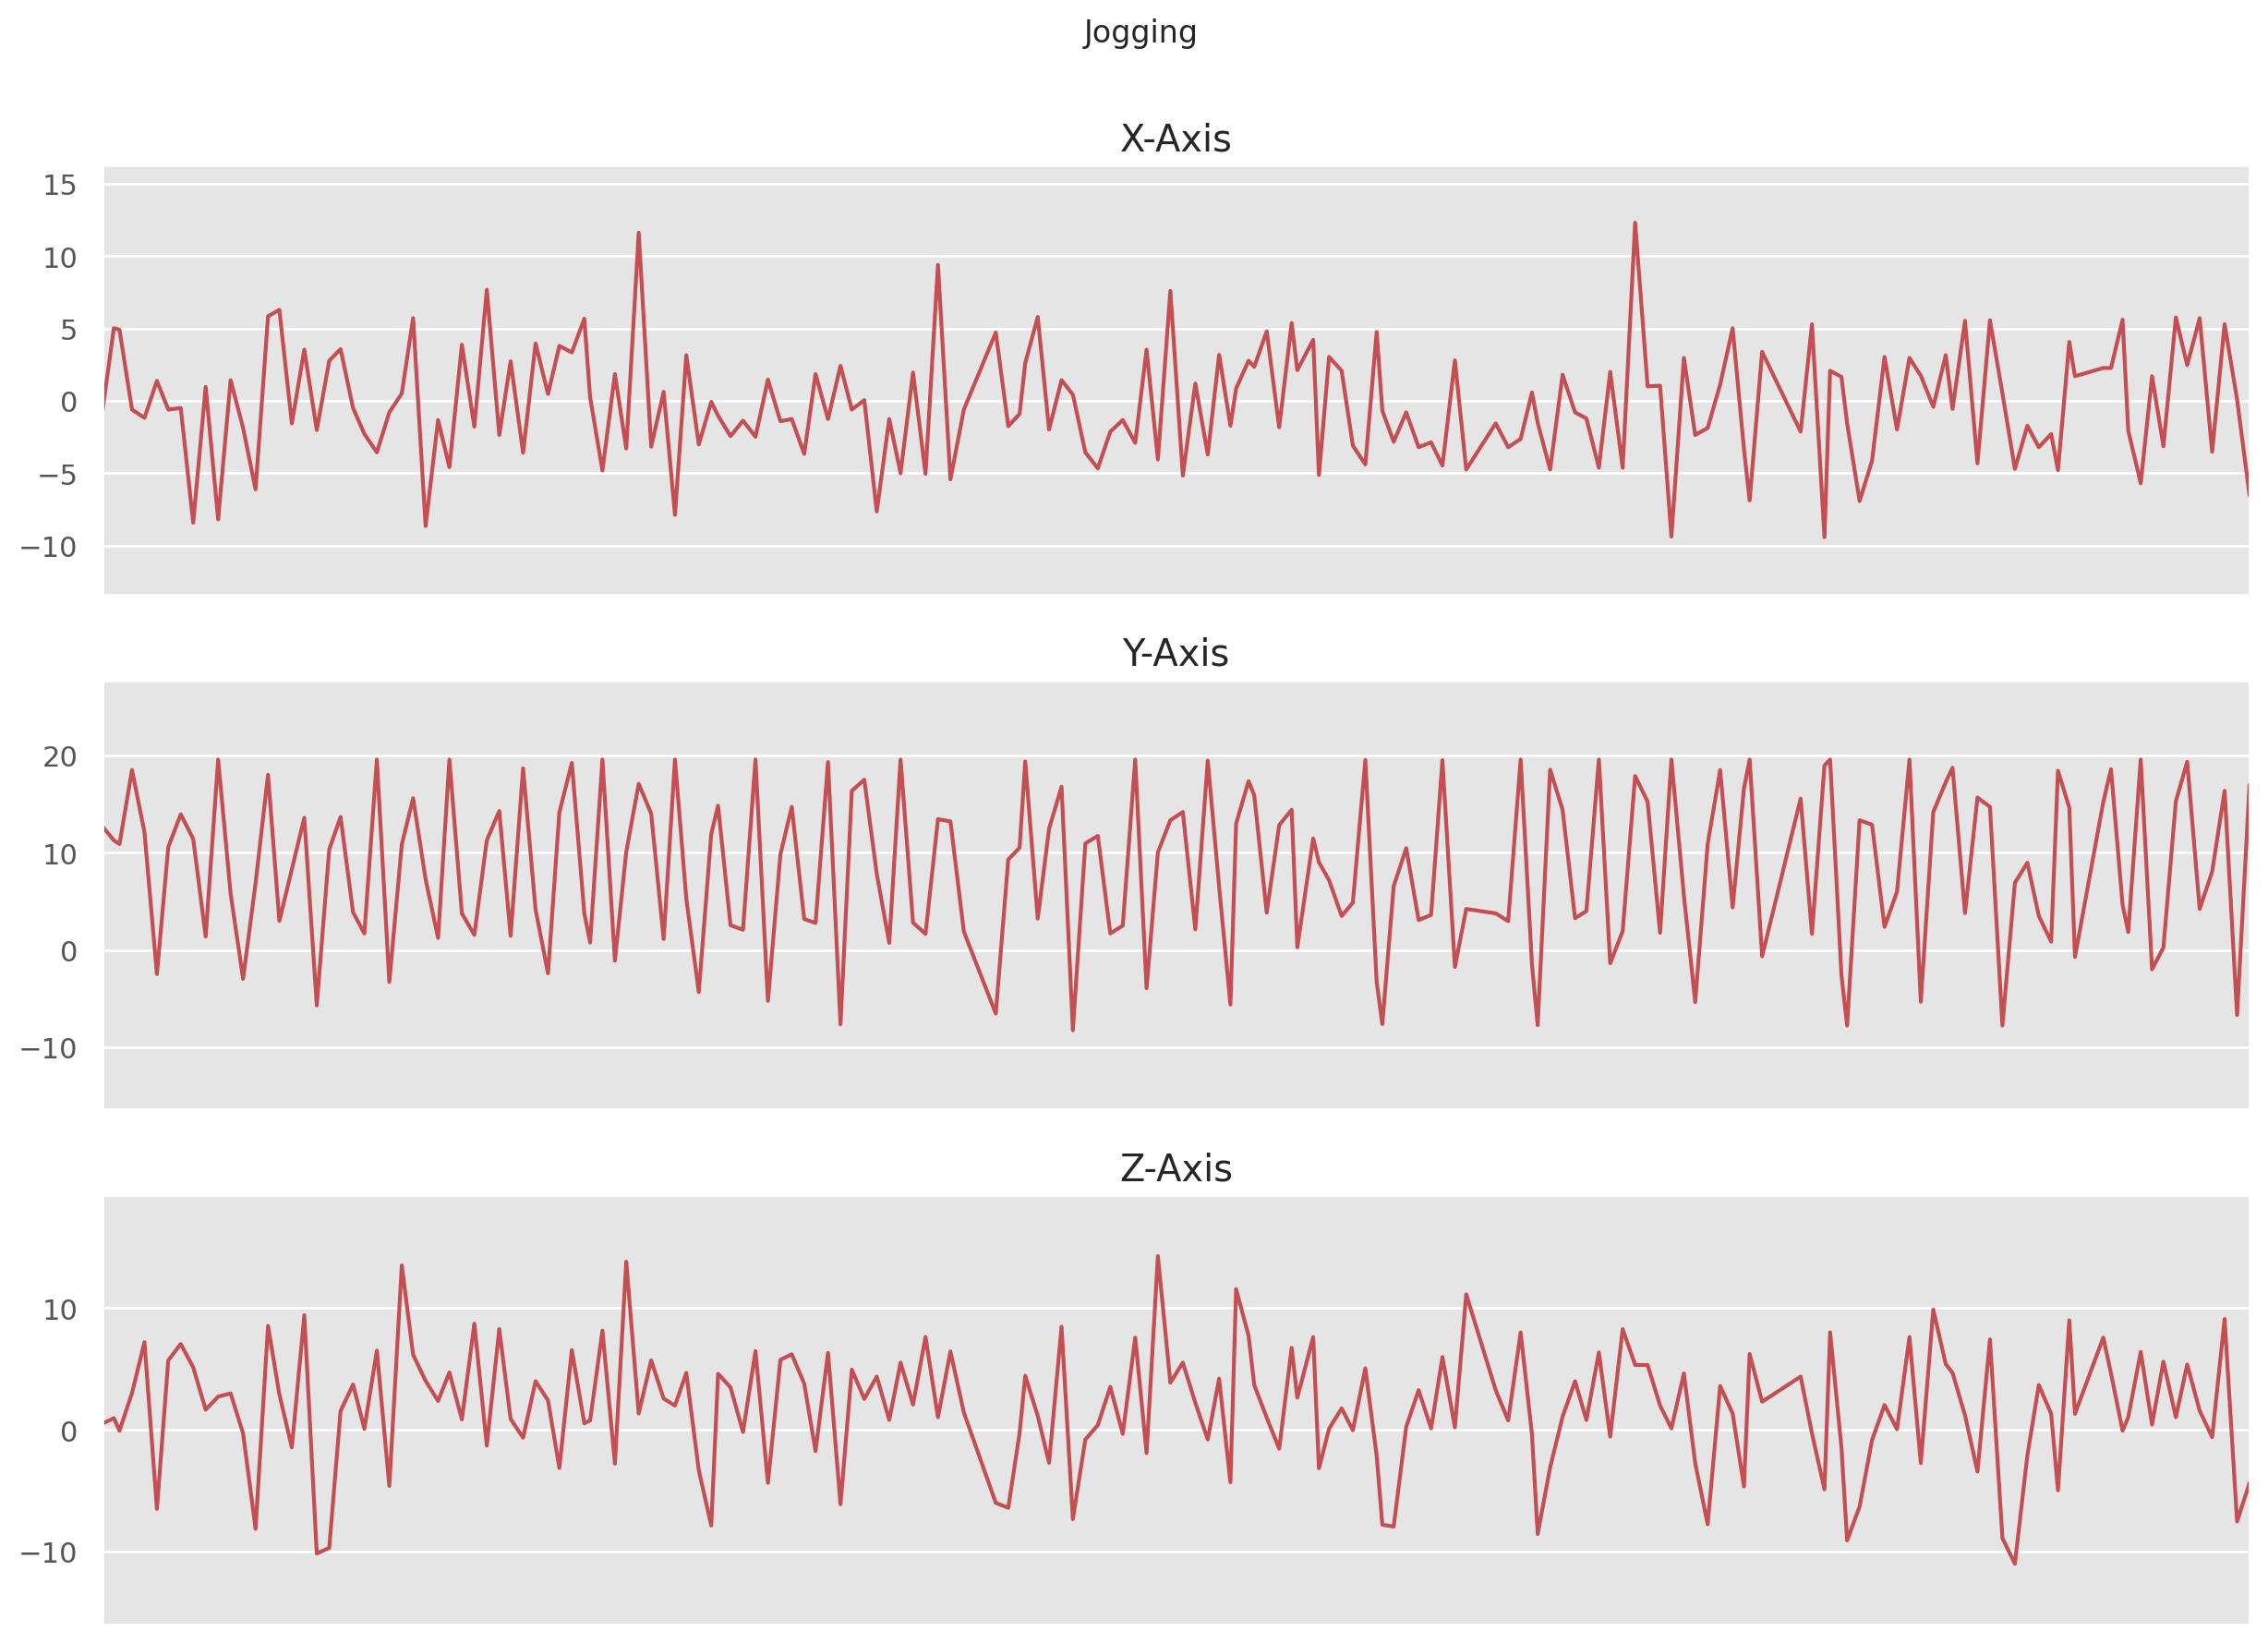

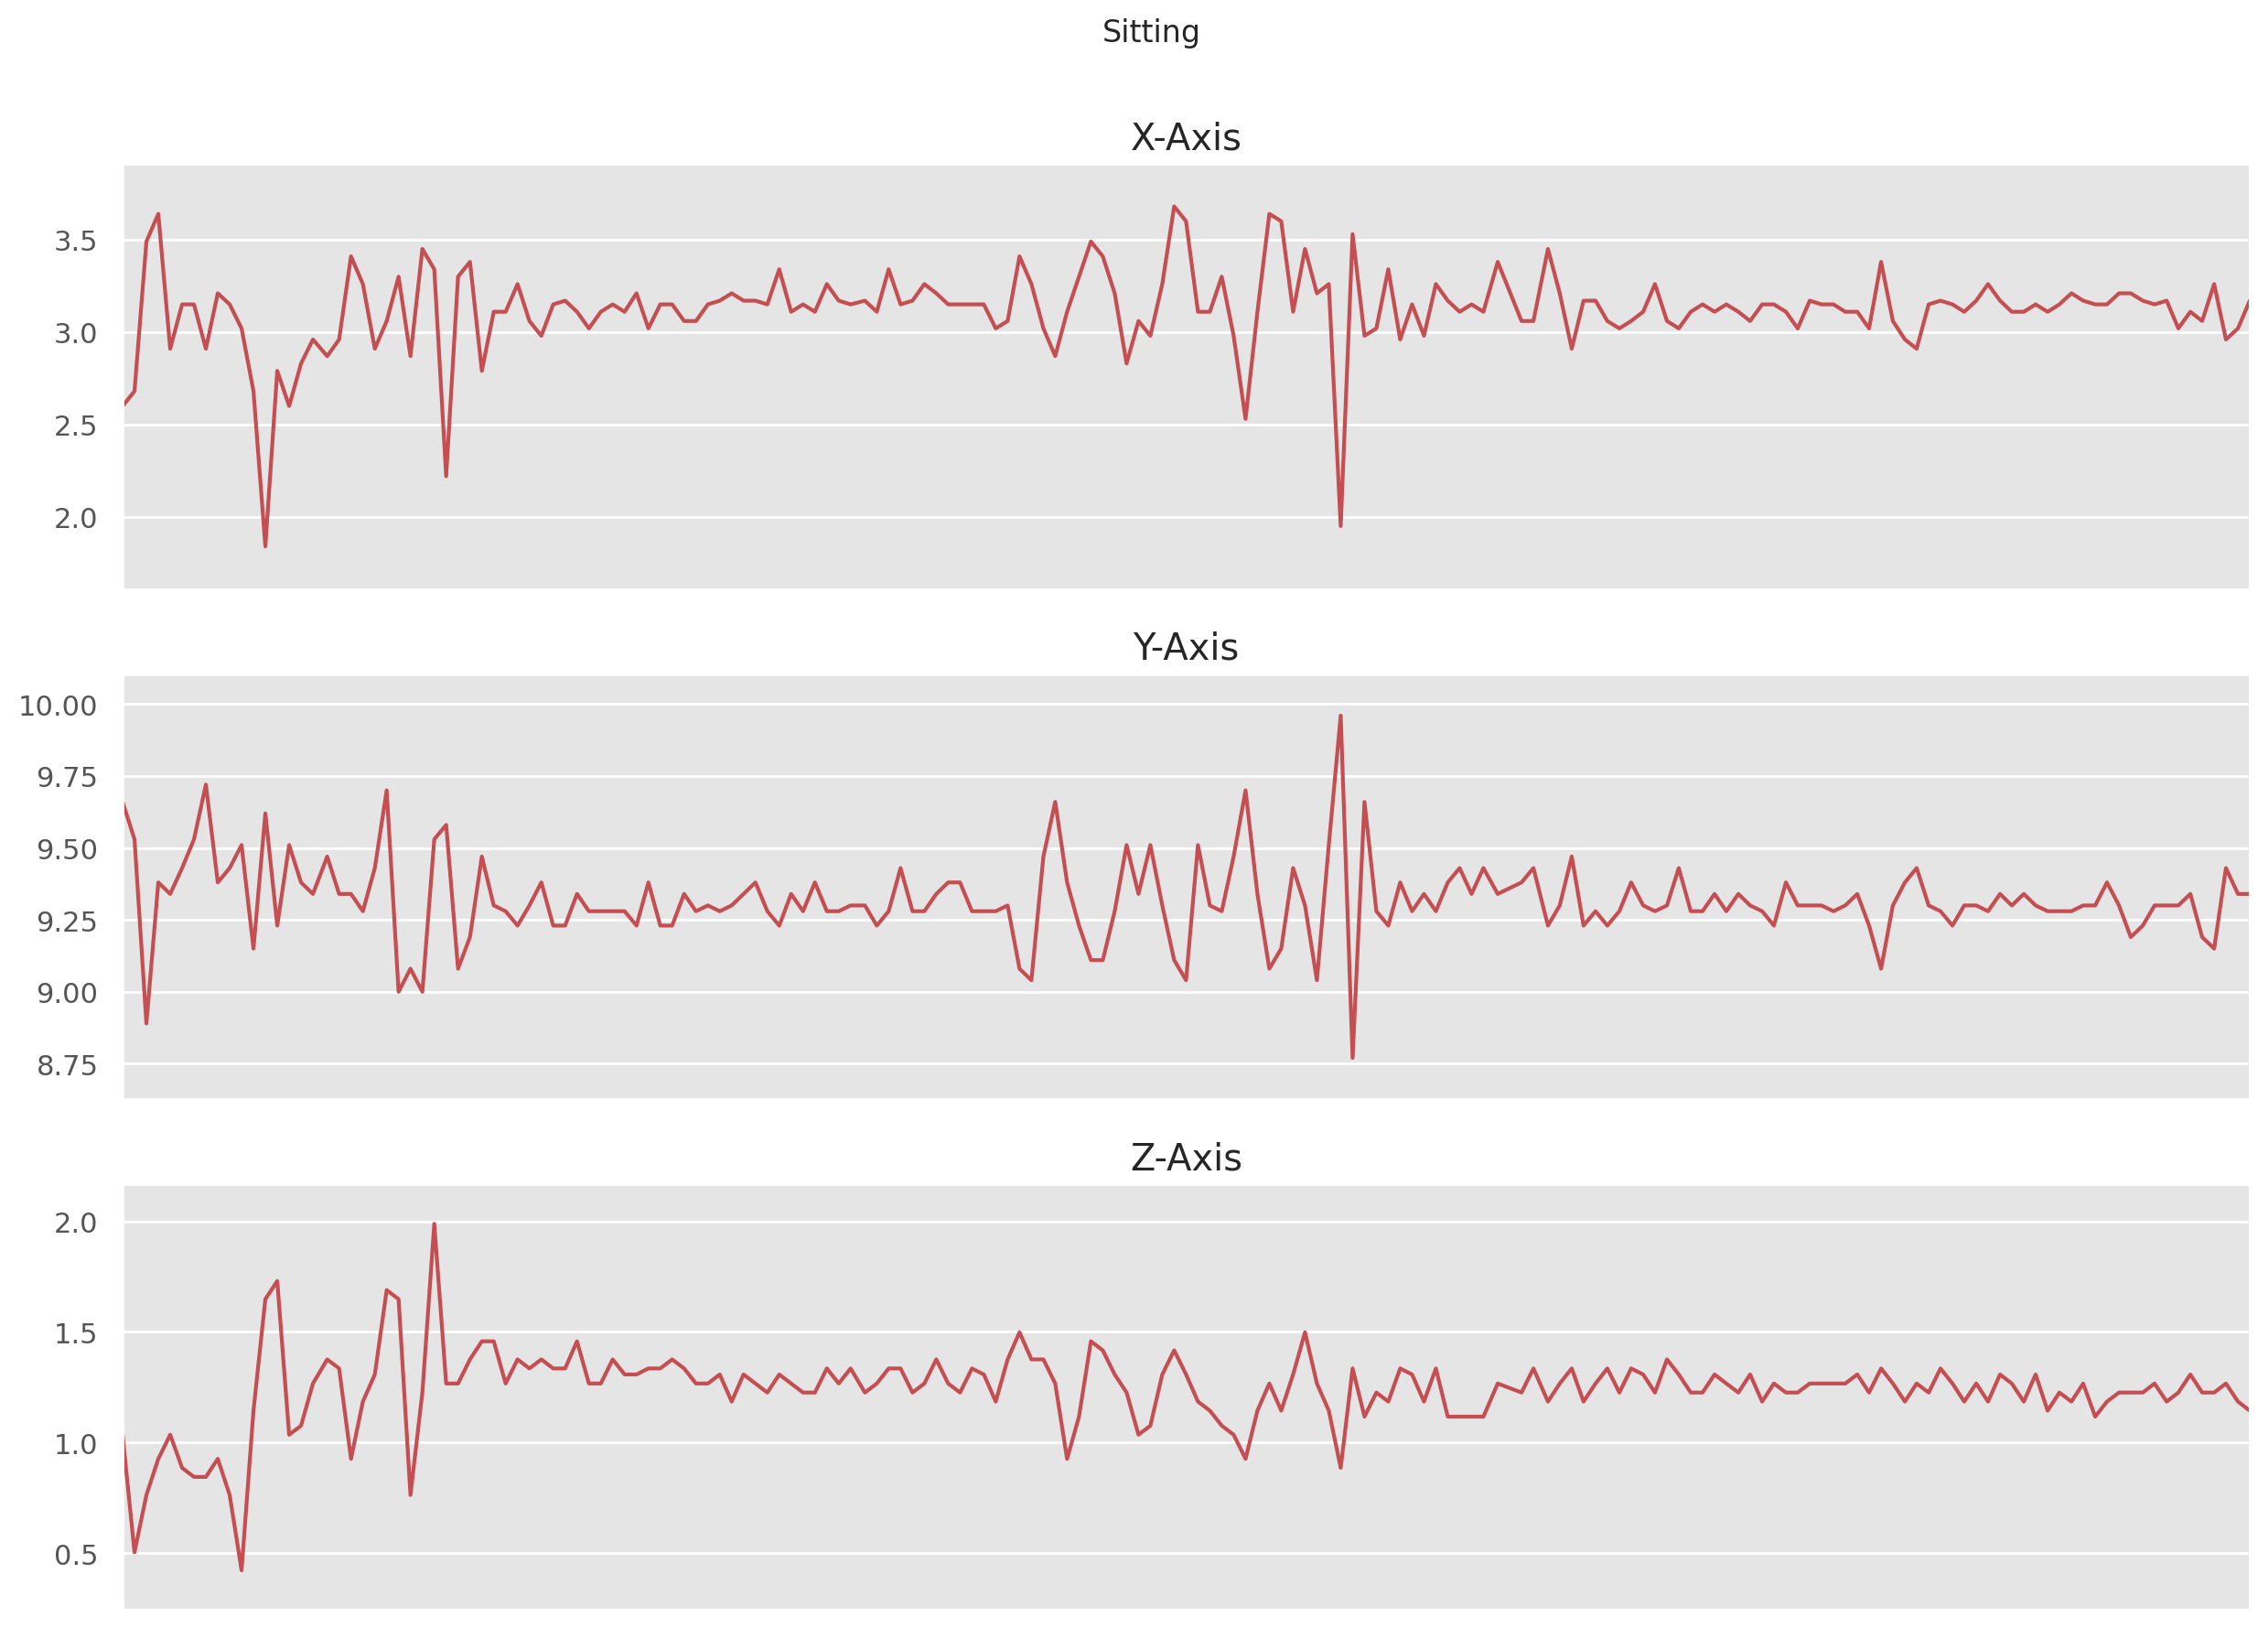

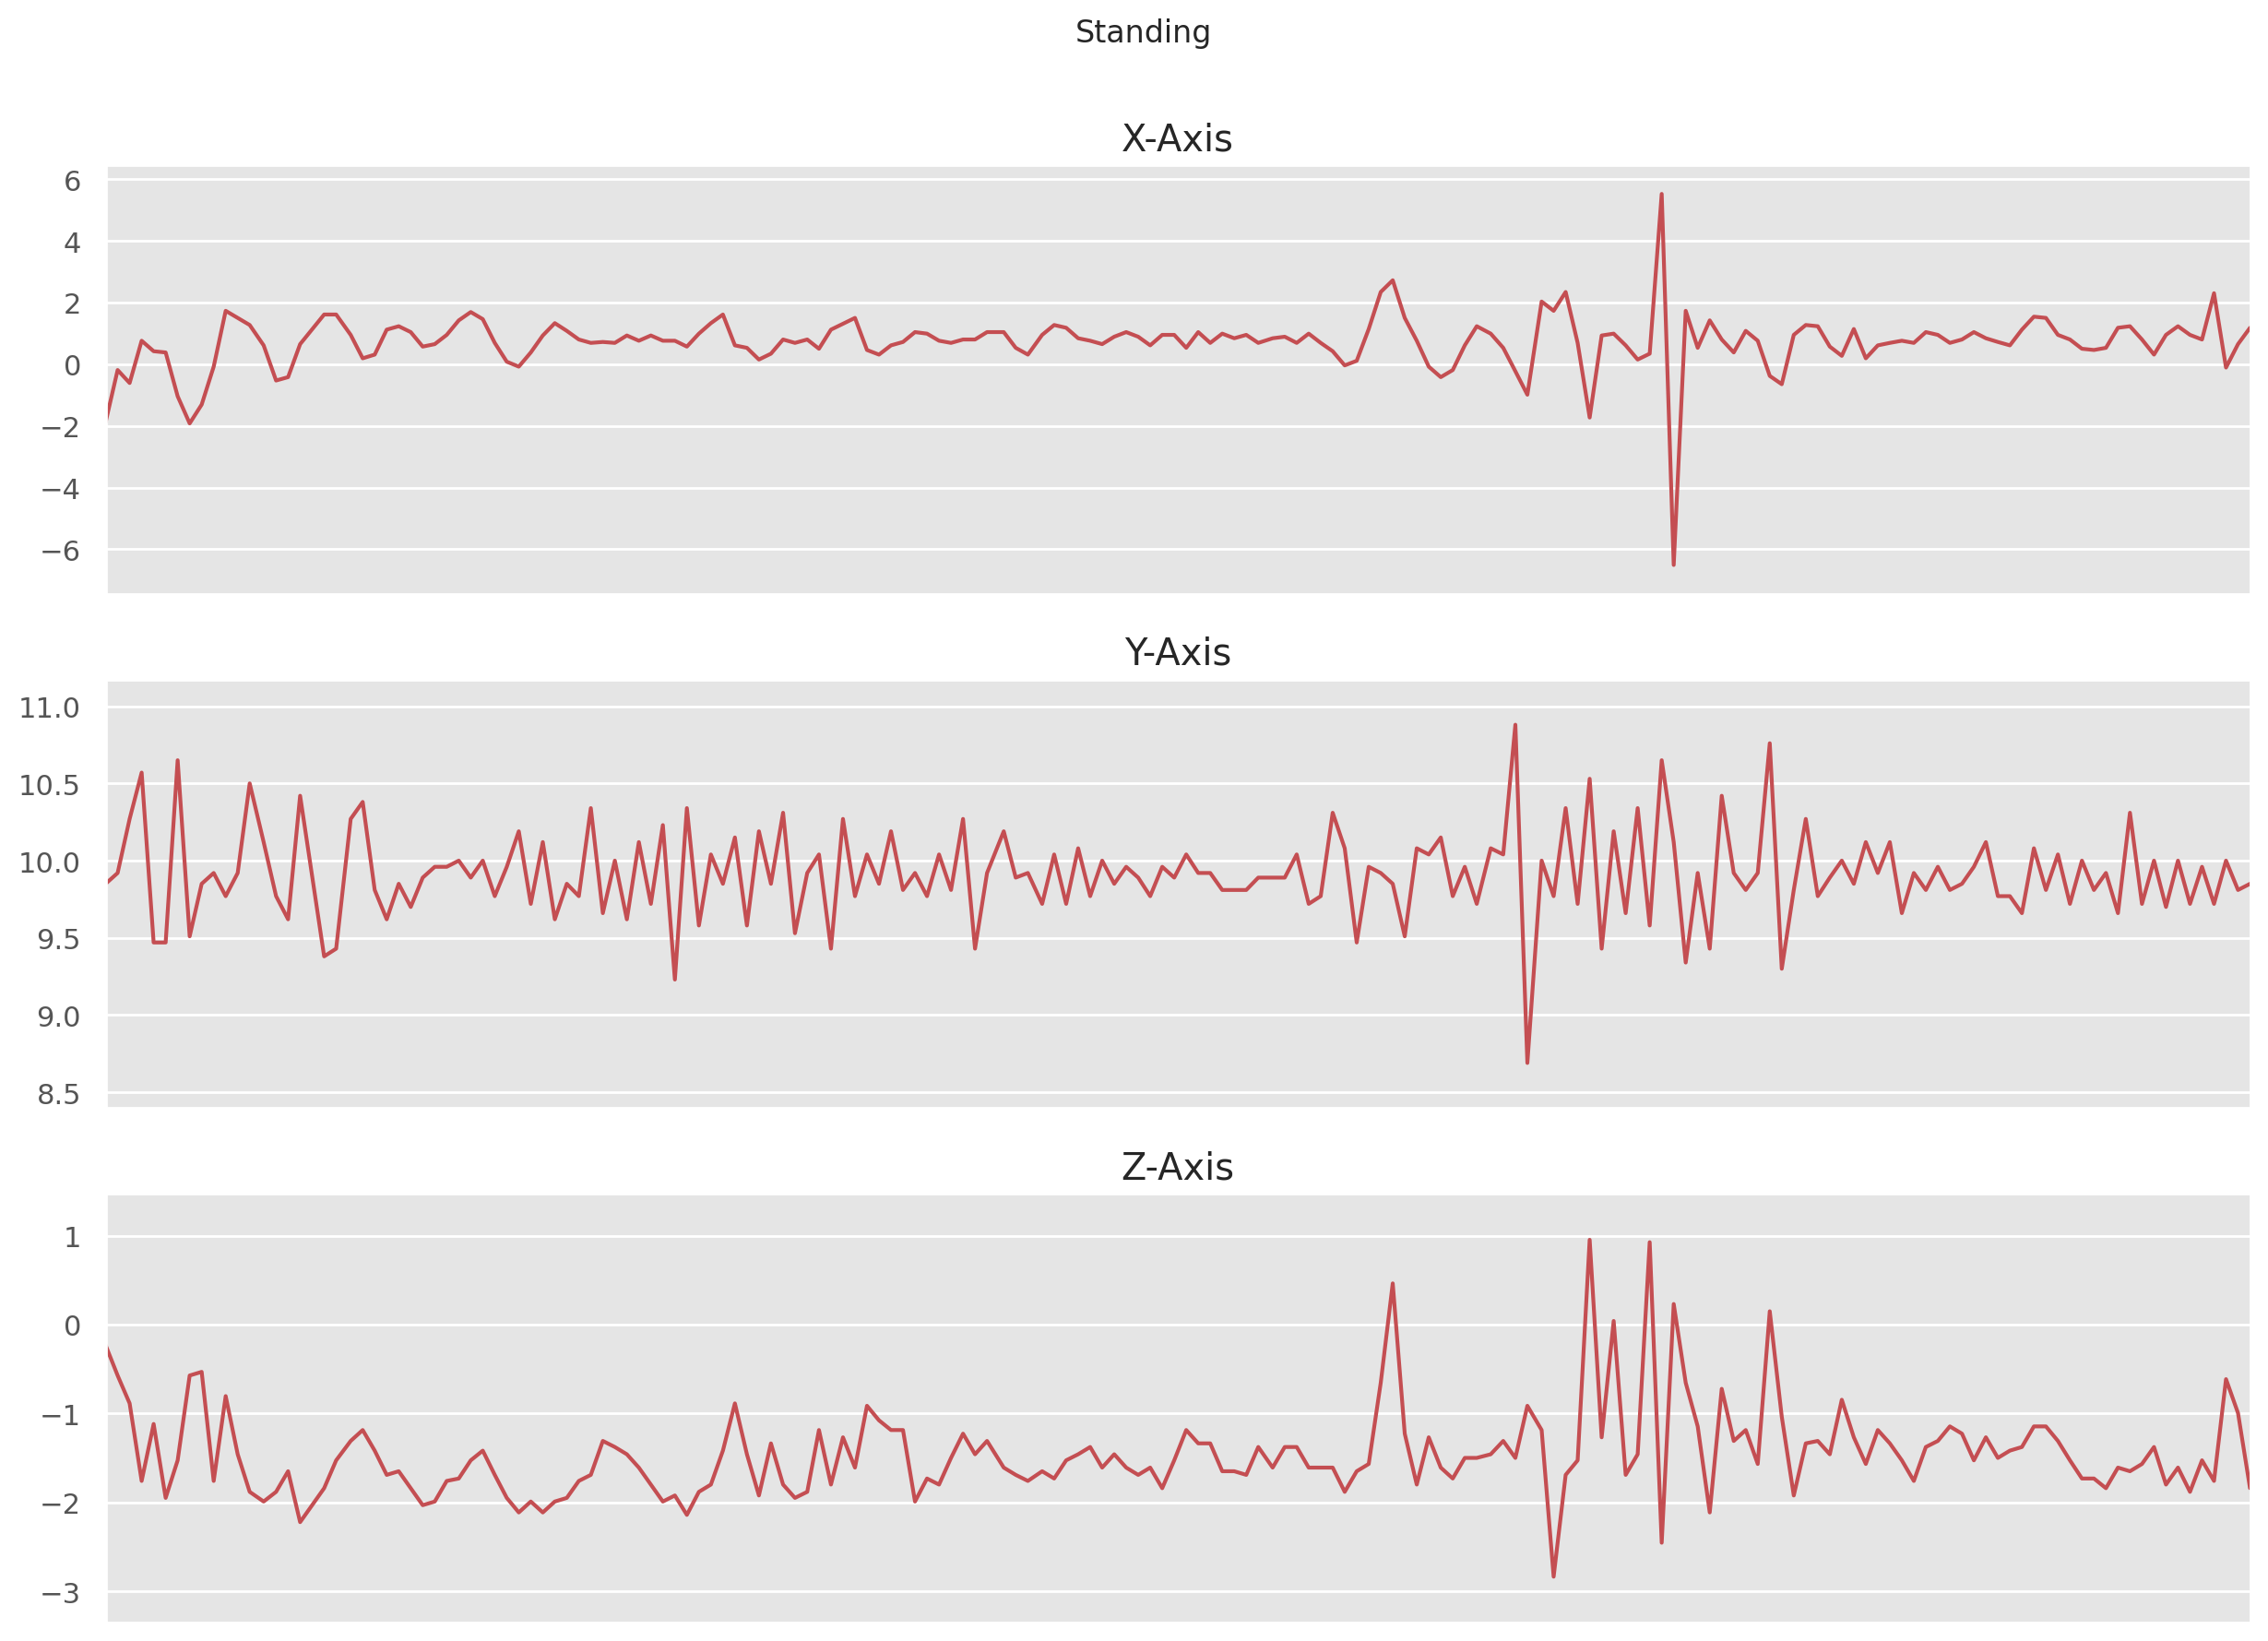

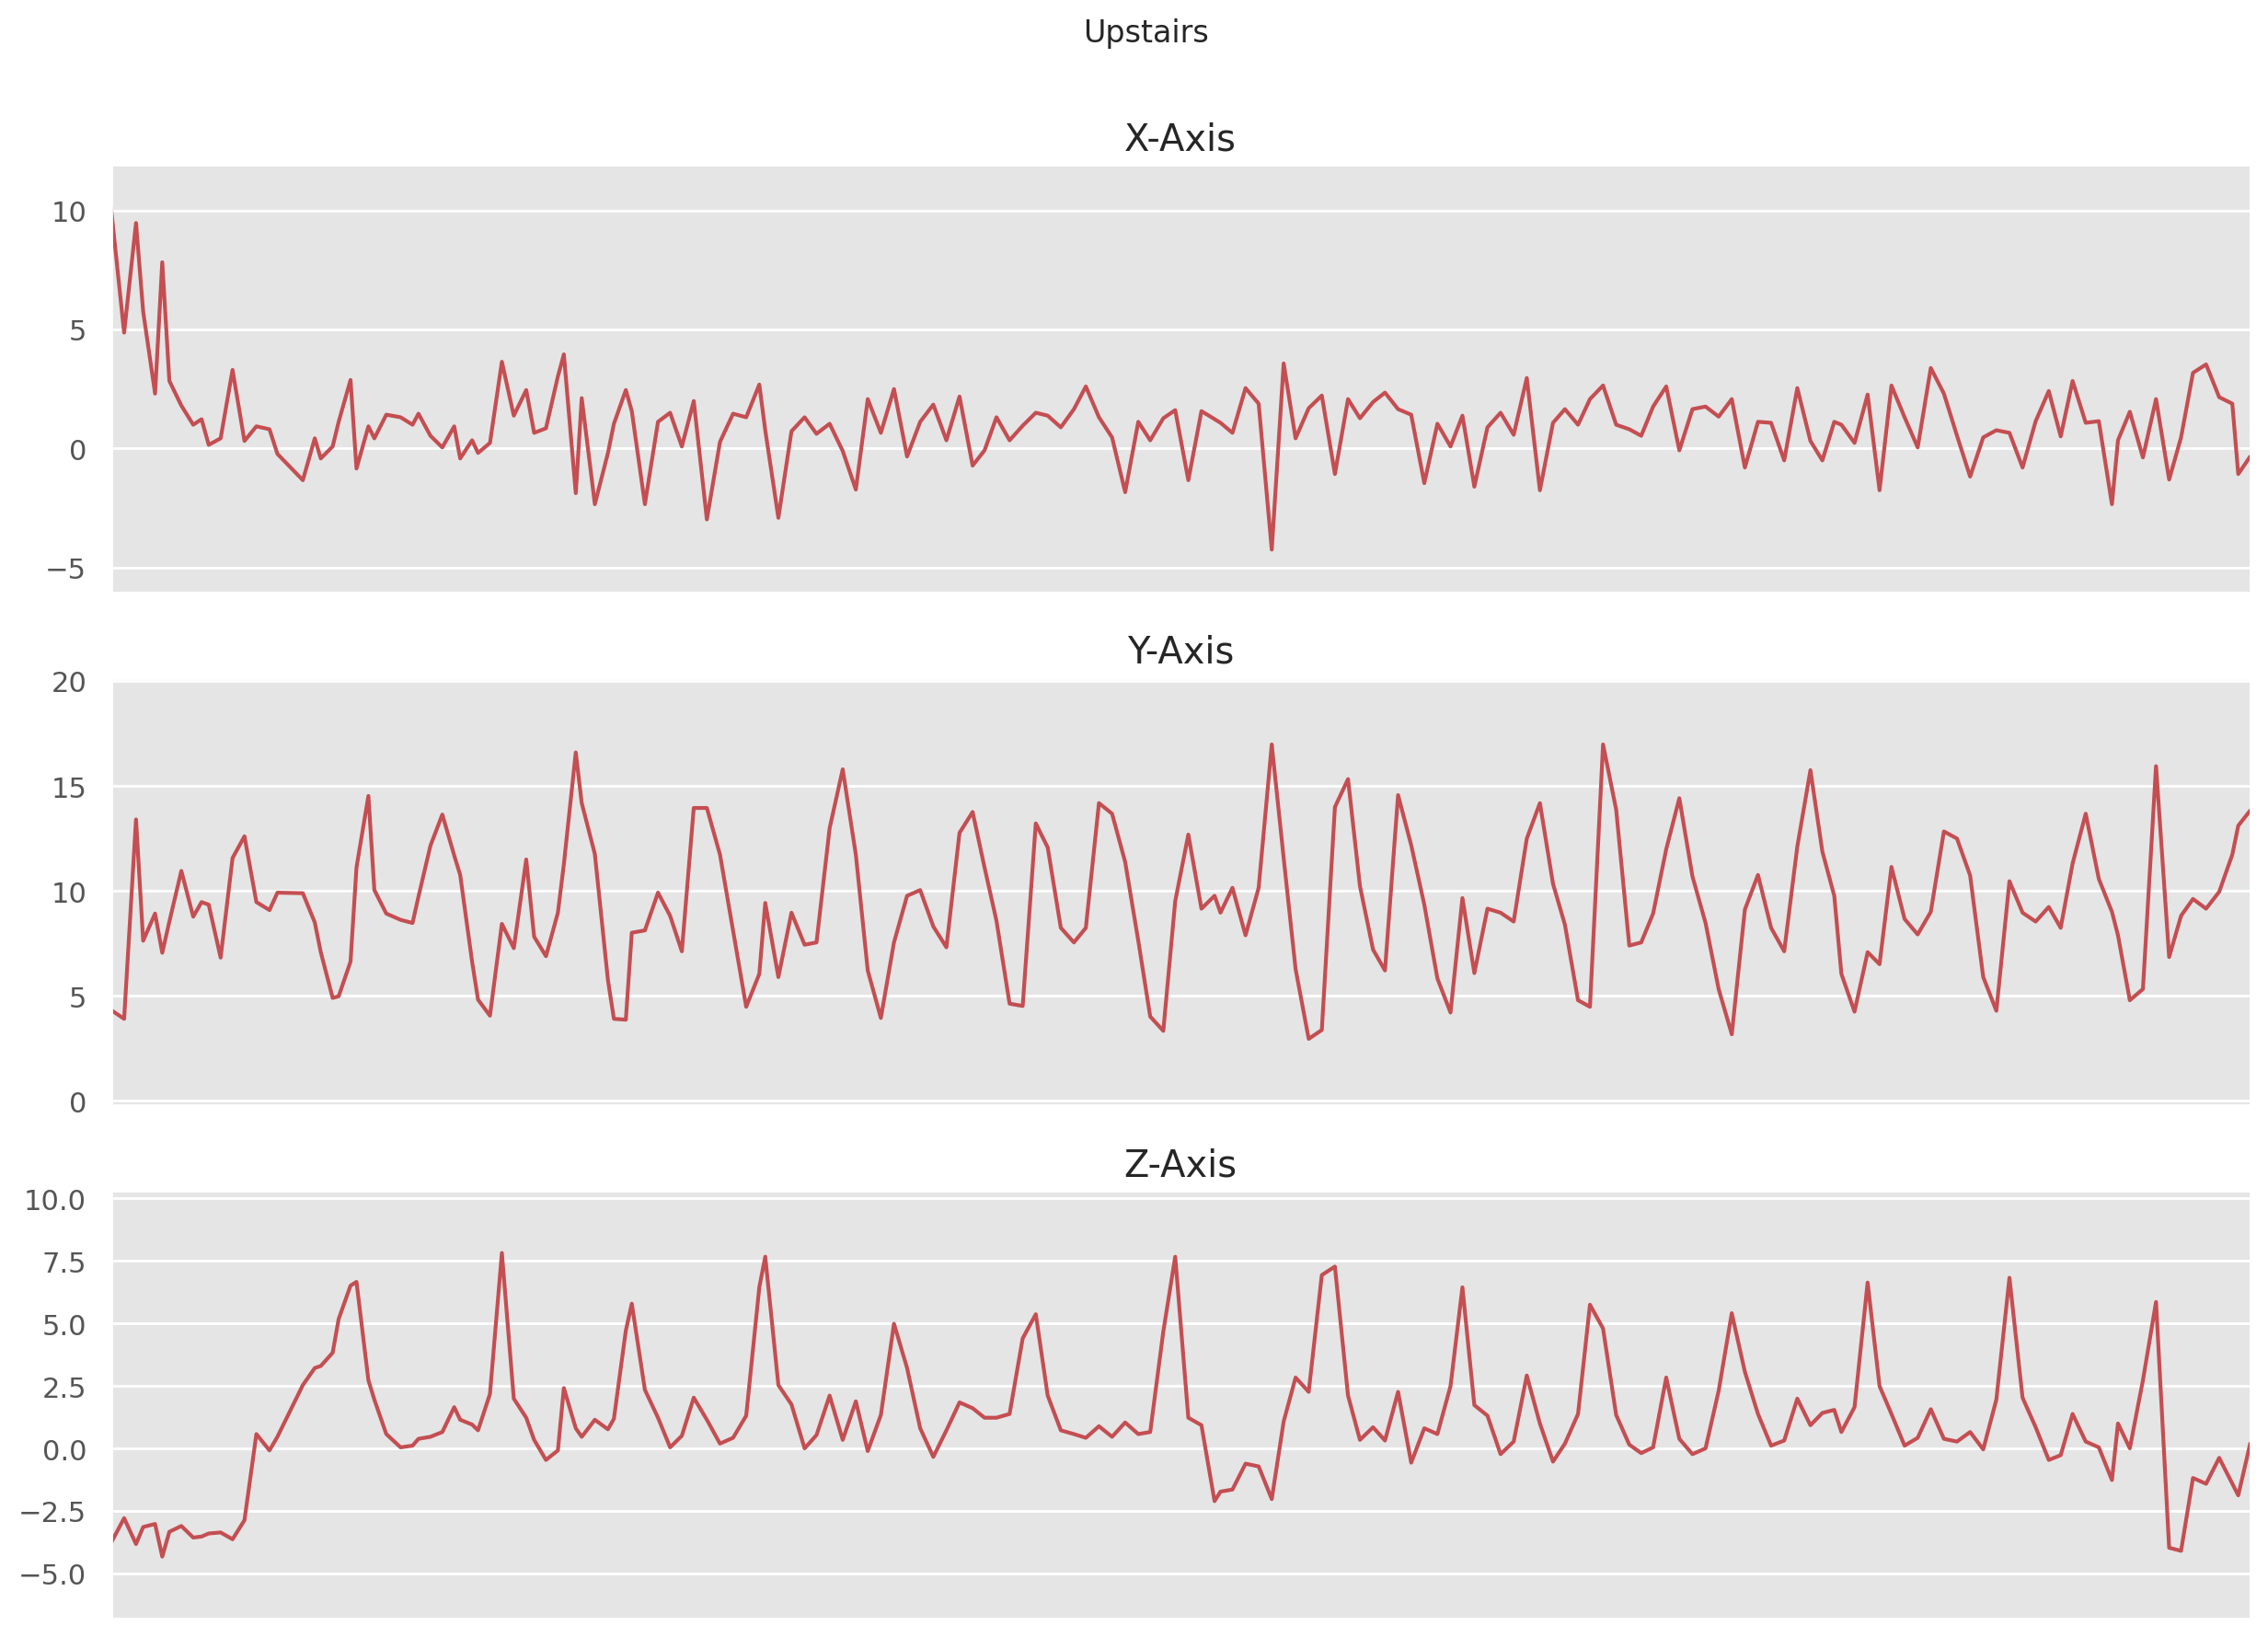

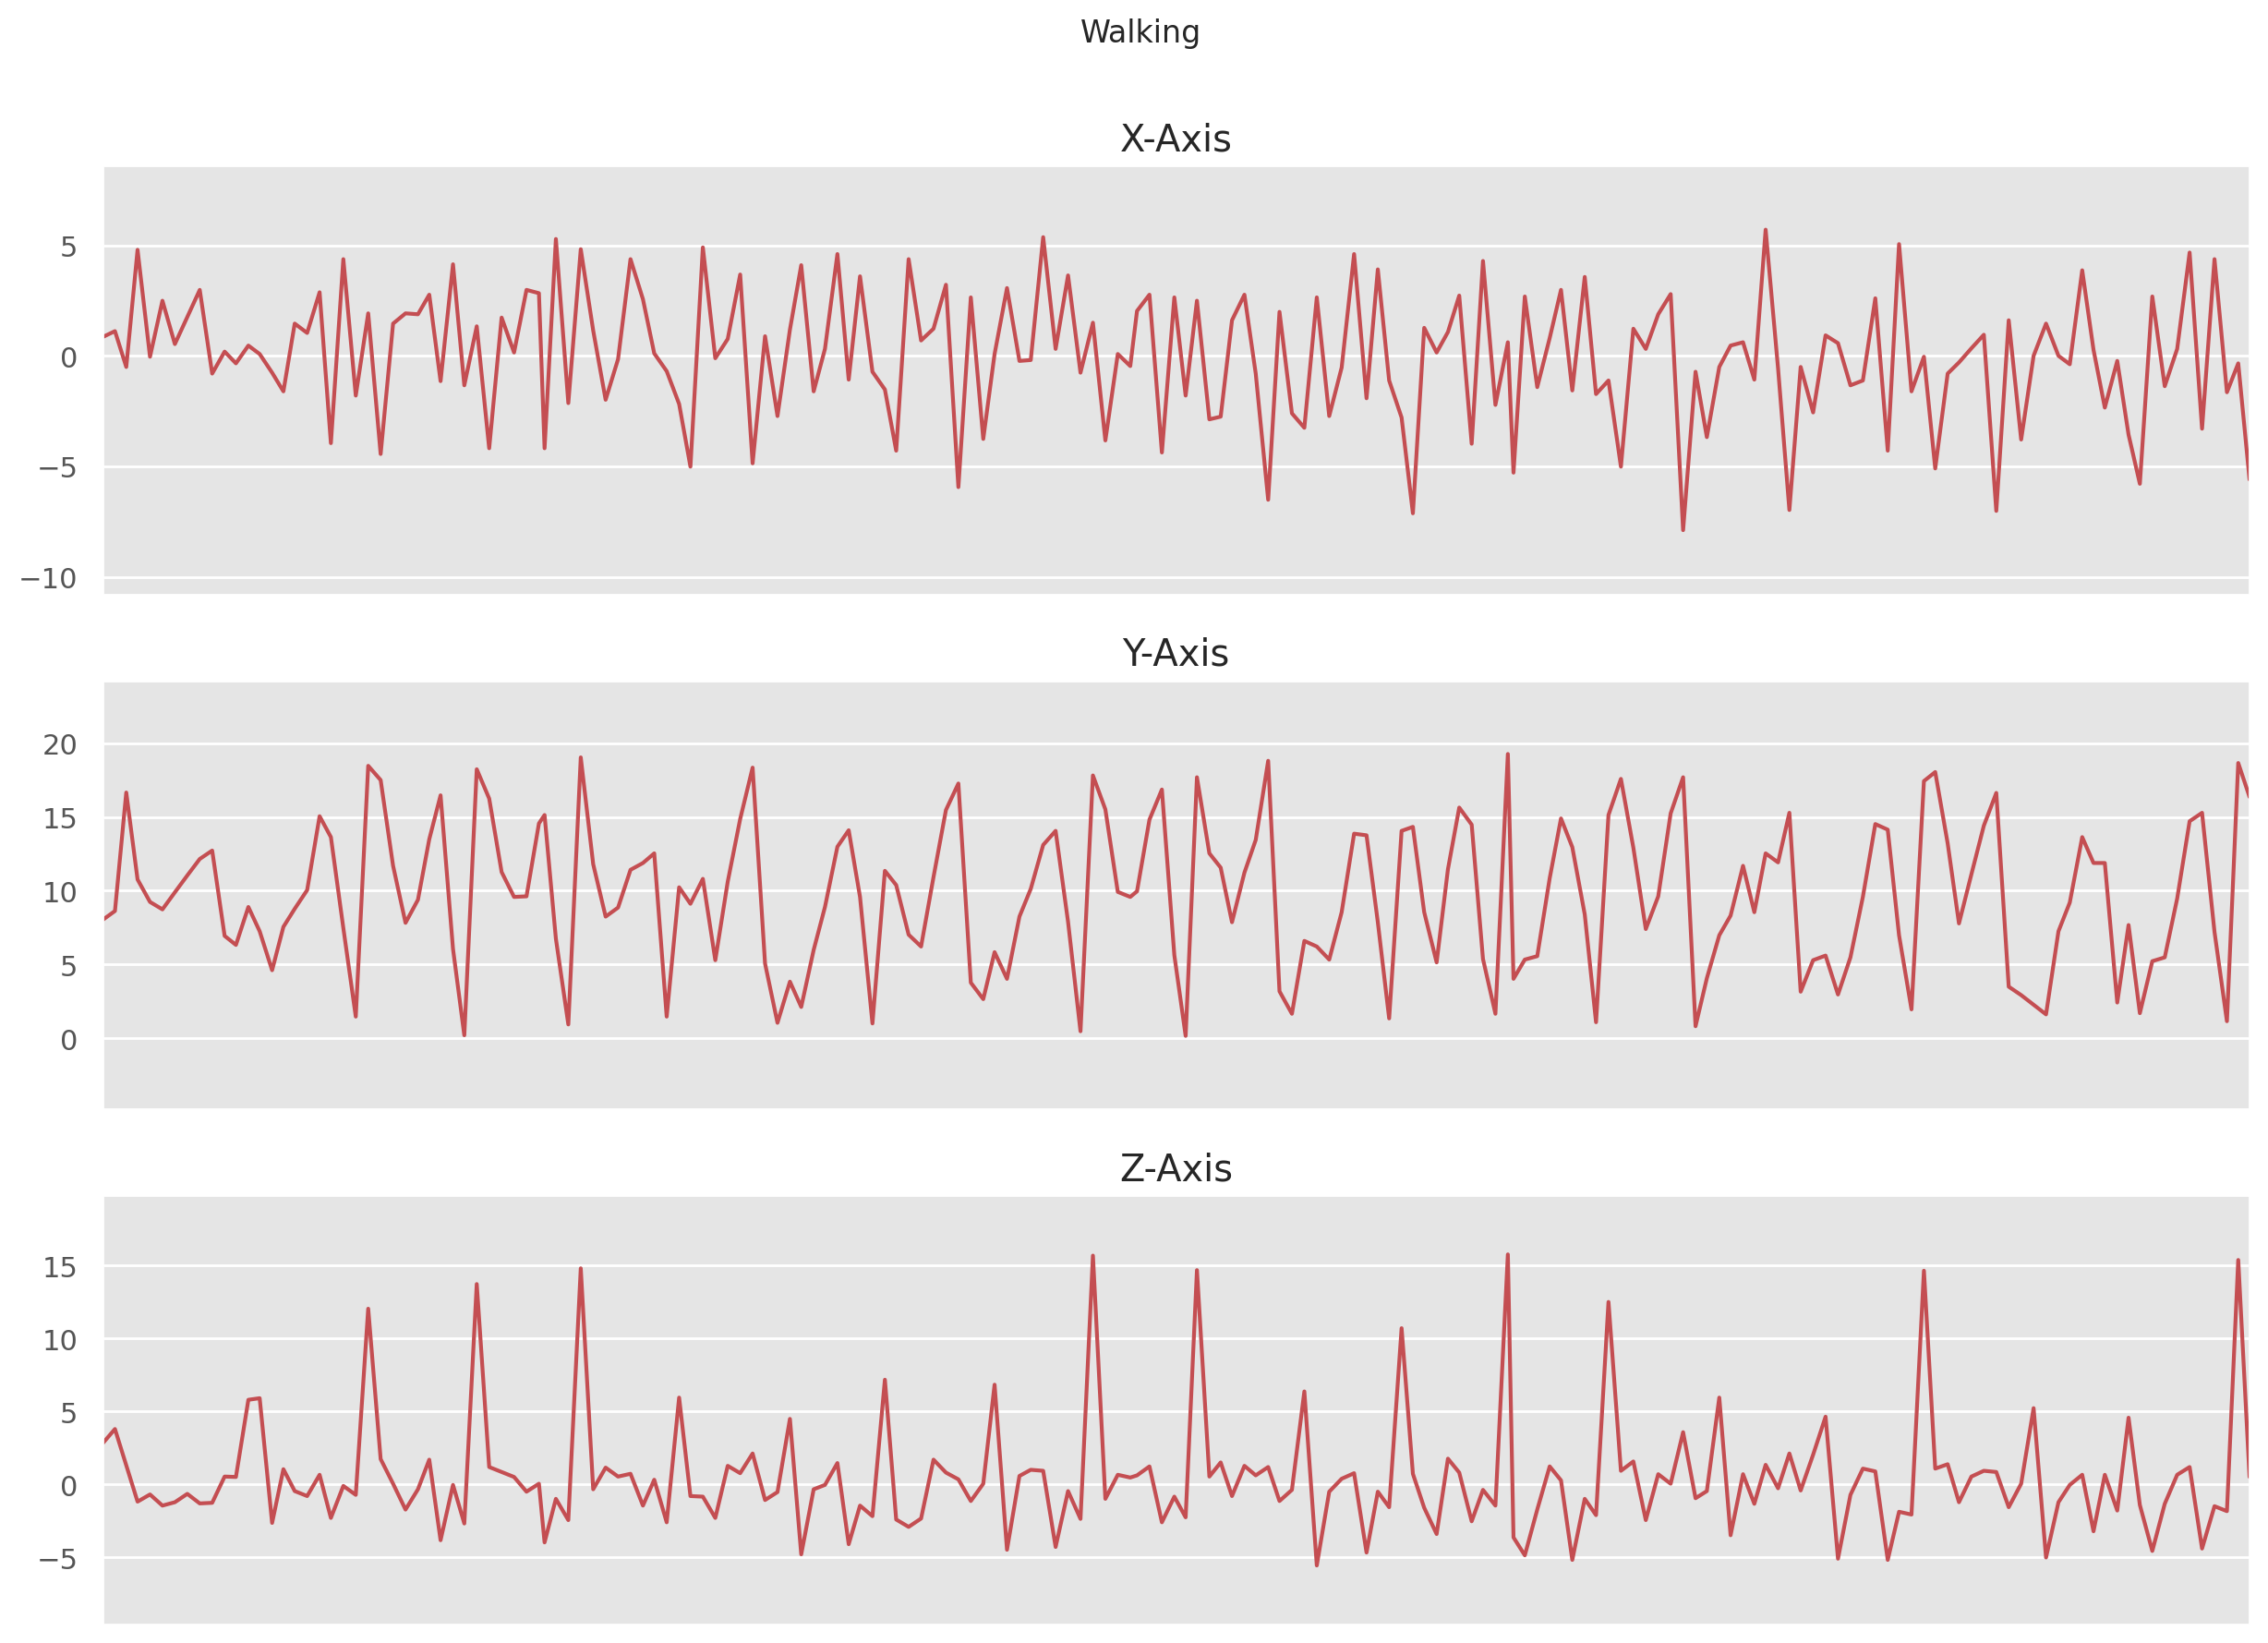

In [14]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [15]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [16]:
df.ActivityEncoded.tail(10)

1098199    2
1098200    2
1098201    2
1098202    2
1098203    2
1098204    2
1098205    2
1098206    2
1098207    2
1098208    2
Name: ActivityEncoded, dtype: int64

In [17]:
set(df.ActivityEncoded)

{0, 1, 2, 3, 4, 5}

### Train Test Split

Wrong split strategy - Only worrying about having at least a few example records per activity is not sufficient. You will run the risk that you have maybe three records of activity "Walking" for person 5 in the training set and one record for activity "Walking" for person 5 in the test set. Of course, with this type of situation, your model will perform great because it has already seen the movement pattern of person 5 during training. Please, always be critical about the performance of your DNN - it might be because of the wrong data split in the first place.

We will keep users with ID 1 to 28 for training the model and users with ID greater than 28 for the test set. This also applies for any other sensor data (e.g. Internet of Things)

In [18]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

## Normalize Training Data

Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization I also decided to round the three features to six digits. You can play around with the optimal number here in order to further increase the performance of your network.

In [19]:
# Normalize features for training data set (values between 0 and 1)
max_data = []
for axis in ['x-axis','y-axis','z-axis']:
    max_data.append((axis, df_train[axis].max()))
    df_train[axis] = df_train[axis] / df_train[axis].max()
max_data = dict(max_data)
max_data

/tmp/ipykernel_58099/2531109627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[axis] = df_train[axis] / df_train[axis].max()


{'x-axis': 19.95, 'y-axis': 20.04, 'z-axis': 19.61}

In [20]:
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

## Reshape Data

The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let's create another function for this called "create_segments_and_labels". This function will take in the dataframe and the label names (the constant that we have defined at the beginning) as well as the length of each record. In our case, let's go with 40 steps. Taking into consideration the 20 Hz sampling rate, this equals to 4 second time intervals (calculation: 0.05 * 80 = 4). Besides reshaping the data, the function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity).

In [21]:
print(TIME_PERIODS)
print(STEP_DISTANCE)
print(LABEL)

80
40
ActivityEncoded


In [22]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [23]:
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

By now, you should have both 20,868 records in x_train as well as in y_train. Each of the 20,868 records in x_train is a two dimensional matrix of the shape 80x3. 

In [24]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [25]:
#x_train[0]

For constructing our deep neural network, we should now store the following dimensions:
-  Number of time periods: This is the number of time periods within one record (since we wanted to have a 2 second time interval, this number is 40 in our case)
-  Number of sensors: This is 3 since we only use the acceletion over the x, y, and z axis
-  Number of classes: This is the amount of nodes for our output layer in the neural network. Since we want our neural network to predict the type of activity, we will take the number of classes from the encoder that we have used earlier.

In [26]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


The data that we would like to feed into our network is 2-dimensional (80x3). Unfortunately, Keras and CoreML in conjunction are not able to process multi-dimensional input data. Therefore we need to "flatten" the data for our input layer into the neural network. Instead of feeding a matrix of shape 80x3 we will feed in a list of 240 values.

In [27]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20868, 240)
input_shape: 240


Before continuing, we need to convert all feature data (x_train) and label data (y_train) into a datatype accepted by Keras.

In [28]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

We are almost done with the preparation of our data. One last step we need to do is to conduct one-hot-encoding of our labels. Please only execute this line once!

In [29]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


## Create 1D CNN Model in Keras

By now, you have completed all the heavy-lifting on your side. The data is ready in such a format that Keras will be able to process it. I have decided to create a neural network with 3 hidden layers of 100 fully connected nodes each.

Important node: as you remember, we have reshaped our input data from a 80x3 matrix into a vector of length 240. In order to reverse this, our first layer in the neural network will reshape the data into the "old" format. The last two layers will again flatten the data and then run a softmax activation function in order to calculate the probability for each class. Remember, that we are working with six classes in our case (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking).

In [30]:
# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Dropout(0.3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 80, 3)             0         
                                                                 
 conv1d (Conv1D)             (None, 71, 100)           3100      
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 100)           100100    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 100)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 160)           160160    
                                                        

2023-11-22 15:22:33.042007: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Fit the DNN Model in Keras

Next, we will fit / train the model with our training data that we have prepared earlier. We will define an early stopping callback monitor on training accuracy: if the training fails to improve for two consecutive epochs, then the training will stop with the best model. The hyperparameter used for the training are quite simple: We will use a batch size of 400 records and will train the model for 50 epochs. For model training, we will use a 80:20 split to separate training data and validation data. It is that simple. So let's go ahead and train our model. There are some good explanations out there on the different hyperparameters, for instance [here](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9).

In [31]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_CNN/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
42/42 [==============================] - 12s 264ms/step - loss: 0.9000 - accuracy: 0.6702 - val_loss: 0.6488 - val_accuracy: 0.8148
Epoch 2/50
42/42 [==============================] - 11s 261ms/step - loss: 0.4717 - accuracy: 0.8251 - val_loss: 0.4624 - val_accuracy: 0.8450
Epoch 3/50
42/42 [==============================] - 11s 262ms/step - loss: 0.3618 - accuracy: 0.8635 - val_loss: 0.4701 - val_accuracy: 0.8630
Epoch 4/50
42/42 [==============================] - 11s 257ms/step - loss: 0.3053 - accuracy: 0.8882 - val_loss: 0.4702 - val_accuracy: 0.8438
Epoch 5/50
42/42 [==============================] - 11s 272ms/step - loss: 0.2587 - accuracy: 0.9031 - val_loss: 0.4763 - val_accuracy: 0.8318
Epoch 6/50
42/42 [==============================] - 11s 258ms/step - loss: 0.2134 - accuracy: 0.9274 - val_loss: 0.4695 - val_accuracy: 0.8644
Epoch 7/50
42/42 [==============================] - 11s 266ms/step - loss: 0.1972 - accuracy: 0.9356 - val_loss: 0.5665 - val_accuracy: 0.7980

42/42 [==============================] - 11s 260ms/step - loss: 0.0642 - accuracy: 0.9818 - val_loss: 0.7570 - val_accuracy: 0.8287
Epoch 24/50
42/42 [==============================] - 11s 261ms/step - loss: 0.0611 - accuracy: 0.9808 - val_loss: 0.7728 - val_accuracy: 0.8234
Epoch 25/50
42/42 [==============================] - 11s 254ms/step - loss: 0.0525 - accuracy: 0.9827 - val_loss: 0.7200 - val_accuracy: 0.8392
Epoch 26/50
42/42 [==============================] - 11s 264ms/step - loss: 0.0506 - accuracy: 0.9841 - val_loss: 0.7217 - val_accuracy: 0.8352
Epoch 27/50
42/42 [==============================] - 11s 261ms/step - loss: 0.0472 - accuracy: 0.9853 - val_loss: 0.7830 - val_accuracy: 0.8433
Epoch 28/50
42/42 [==============================] - 11s 254ms/step - loss: 0.0439 - accuracy: 0.9851 - val_loss: 0.7483 - val_accuracy: 0.8455
Epoch 29/50
42/42 [==============================] - 10s 250ms/step - loss: 0.0402 - accuracy: 0.9876 - val_loss: 0.7761 - val_accuracy: 0.8608
Epoc

42/42 [==============================] - 10s 250ms/step - loss: 0.0195 - accuracy: 0.9942 - val_loss: 1.1033 - val_accuracy: 0.8313
Epoch 46/50
42/42 [==============================] - 11s 267ms/step - loss: 0.0285 - accuracy: 0.9907 - val_loss: 0.8661 - val_accuracy: 0.8457
Epoch 47/50
42/42 [==============================] - 11s 257ms/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.9395 - val_accuracy: 0.8452
Epoch 48/50
42/42 [==============================] - 11s 265ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.9466 - val_accuracy: 0.8460
Epoch 49/50
42/42 [==============================] - 11s 252ms/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 1.0404 - val_accuracy: 0.8522
Epoch 50/50
42/42 [==============================] - 11s 260ms/step - loss: 0.0130 - accuracy: 0.9966 - val_loss: 1.2133 - val_accuracy: 0.8280


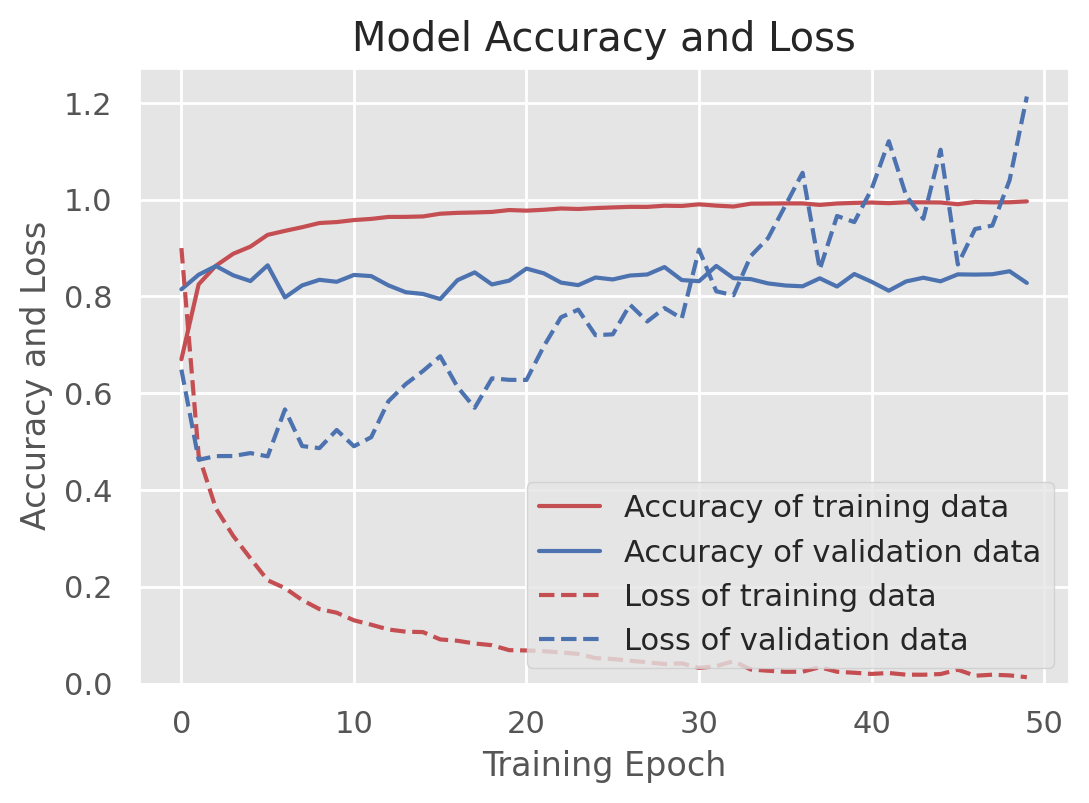

653/653 [==============================] - 7s 11ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      1861
         1.0       0.99      0.95      0.97      6568
         2.0       1.00      0.99      1.00      1049
         3.0       0.99      1.00      1.00       836
         4.0       0.89      0.95      0.92      2342
         5.0       0.99      0.98      0.98      8212

    accuracy                           0.97     20868
   macro avg       0.95      0.97      0.96     20868
weighted avg       0.97      0.97      0.97     20868



In [34]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))


## Check Against Test Data

Let's continue with this model and see how it performs against the test data that we have held back earlier. In our case, we will check the performance against the movements of the six users that the model has not yet seen.

In [35]:
# Normalize features for training data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

/tmp/ipykernel_58099/2135895259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
/tmp/ipykernel_58099/2135895259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
/tmp/ipykernel_58099/2135895259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

206/206 [==============================] - 3s 13ms/step - loss: 0.7072 - accuracy: 0.8896

Accuracy on test data: 0.89

Loss on test data: 0.71


The accuracy on the test data is 76%. This means that our model generalizes well for persons it has not yet seen. Let's see where our model wrongly predicted the labels.

206/206 [==============================] - 2s 11ms/step


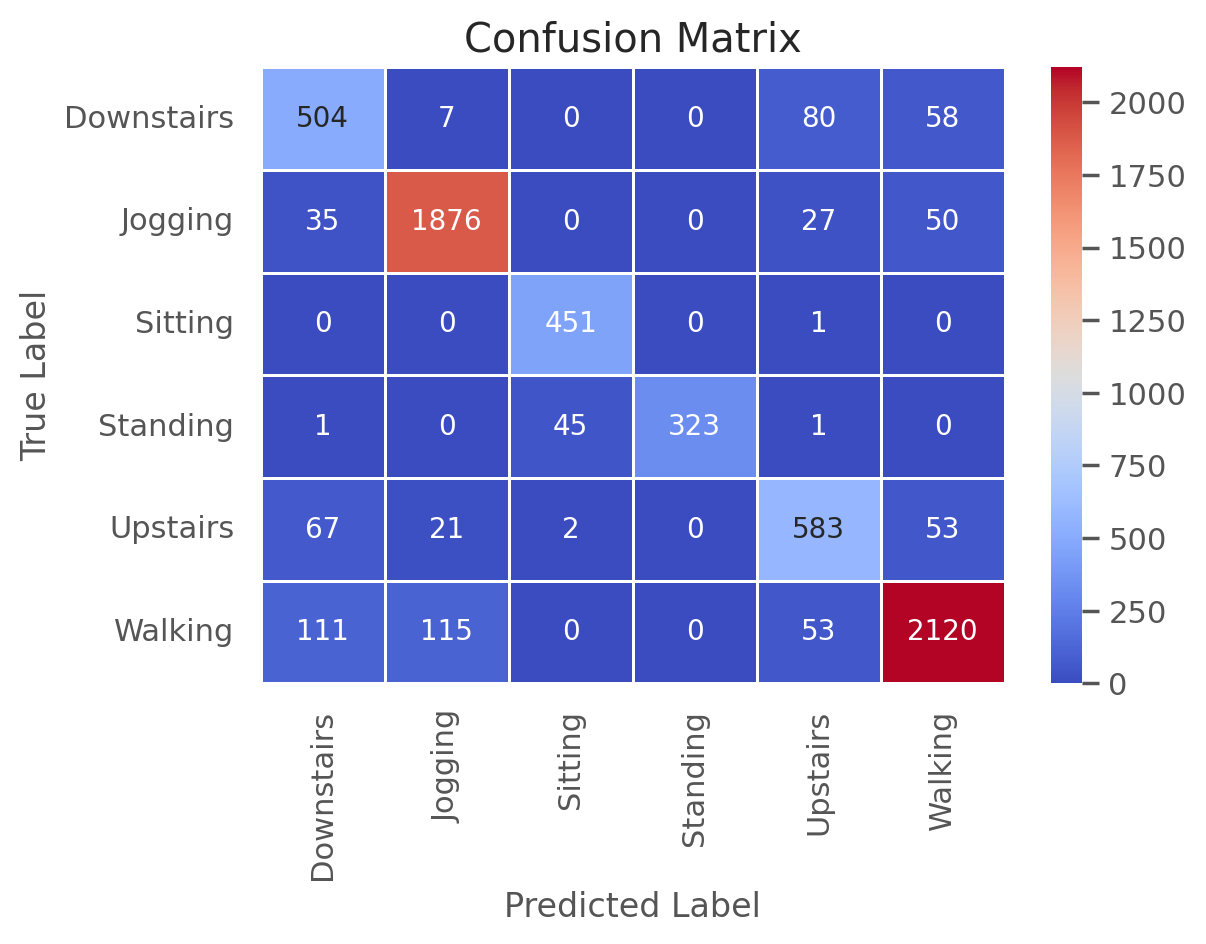

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       649
           1       0.93      0.94      0.94      1988
           2       0.91      1.00      0.95       452
           3       1.00      0.87      0.93       370
           4       0.78      0.80      0.79       726
           5       0.93      0.88      0.91      2399

    accuracy                           0.89      6584
   macro avg       0.87      0.88      0.88      6584
weighted avg       0.89      0.89      0.89      6584



In [36]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

As you can see, the precision of the model is good for predicting jogging (1), sitting (2), standing (3), and walking (5). The model has problems for clearly identifying upstairs and downstairs activities. 

There is of course still great potential for improving the model, e.g. by using more advanced neural network like convolutional neural networks (CNN) or Long Short Term Memory (LSTM). 

## Prediction 

Before using your CoreML model, let's make sure that the export was successful and that both our Keras model as well as the CoreML model provide the same prediction when given a random data set. 

In [37]:
test_record = x_test[1].reshape(1,input_shape)
keras_prediction = np.argmax(model_m.predict(test_record), axis=1)
print('\nPrediction:\t',le.inverse_transform(keras_prediction)[0])
print('\nTruth:\t\t',LABELS[np.argmax(y_test[1])])

1/1 [==============================] - 0s 17ms/step

Prediction:	 Jogging

Truth:		 Jogging
